In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [3]:
#target_wd = "outputs/2022-10-28/TL_1"
#target_wd = "outputs/test_tl_amber"
target_wd = "outputs/2022-10-28/bak_TL3_745"

In [4]:
enable_load = True

if enable_load is True:
    train_hist = pd.read_table(os.path.join(target_wd, "train_history.csv"), sep=",", header=None)
    best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
    best_arc_seq = train_hist.loc[best_trial_id, 3:].iloc[0].tolist()
    # loading from h5 is not working yet
    # AttributeError: 'str' object has no attribute 'Layer_type'
    #model = tf.keras.models.load_model(
    #    os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"),
    #    custom_objects={
    #        "KinnLayer": amb.model_fn.custom_objects['kinnlayer'],
    #        "InceptionLayer": amb.model_fn.custom_objects['inceptionlayer'],
    #        "AttentionPooling": amb.model_fn.custom_objects['attentionpooling'],
    #        "Bidirectional": amb.model_fn.custom_objects['bidirectional'],
    #    })
    print(train_hist.loc[best_trial_id])
else:
    best_trial_id = 0
    best_arc_seq = [5,0,0,1,5,0,3,4]

    0                        1         2   3   4   5   6   7   8   9   10
10  10  [0, 0.7454347888604052]  0.745435   5   2   4   3   4   2   0   4


In [5]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2022-10-28 16:14:04,040 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [6]:
model = amb.model_fn(best_arc_seq)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 25, 13)]     0                                            
__________________________________________________________________________________________________
inception_0 (InceptionLayer)    (None, 25, 16)       744         input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 25, 16)       0           inception_0[0][0]                
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 25, 16)       0           dropout[0][0]                    
____________________________________________________________________________________________

In [7]:
with h5py.File("./data/inVivoData.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()], store["valid/k"][()]

In [8]:
untrained_benchmarks = {
    "Kleinsitver": amb.reward_fn(model, t1)[0],
    "Listgarten": amb.reward_fn(model, t2)[0],
    "Listgarten_Indel": amb.reward_fn(model, t3)[0],
    "Finkelstein": amb.reward_fn(model, valid_data)[0]
}
untrained_benchmarks

{'Kleinsitver': 0.1484133019330644,
 'Listgarten': 0.056546218602954154,
 'Listgarten_Indel': 0.07487409439422166,
 'Finkelstein': 0.9097616189069685}

In [9]:
load_trained_weights = True
if enable_load and load_trained_weights:
    model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    benchmarks = {
        "Kleinsitver": amb.reward_fn(model, t1)[0],
        "Listgarten": amb.reward_fn(model, t2)[0],
        "Listgarten_Indel": amb.reward_fn(model, t3)[0],
        "Finkelstein": amb.reward_fn(model, valid_data)[0]
    }
    print(benchmarks)

{'Kleinsitver': 0.35829664303545483, 'Listgarten': 0.20202517079985877, 'Listgarten_Indel': 0.2602607432732272, 'Finkelstein': 0.7006106516058949}


In [10]:
retrain = False
if retrain is True:
    from tensorflow.keras.optimizers import SGD, Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    batch_size = 25000
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0001 if load_trained_weights else 0.005,
        decay_steps=int(1000000/batch_size)*(10 if load_trained_weights else 30),  # decay lr every 10 epochs
        decay_rate=0.9,
        staircase=False)
    model.compile(**{
        'loss': 'binary_crossentropy', 
        'metrics': ['acc', tf.keras.metrics.AUC(curve='PR')],
        'optimizer': Adam(learning_rate=lr_schedule),
    })
    wd = os.path.join(target_wd, "weights", "trial_%i"%best_trial_id)
    checkpointer = ModelCheckpoint(
        filepath=os.path.join(wd,"bestmodel_retrain.h5"), 
        monitor="val_auc_1",
        mode='max', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True)
    earlystopper = EarlyStopping( monitor="val_auc_1", mode='max', patience=15, verbose=1)
    hist = model.fit(
        amb.manager.train_data[0],
        amb.manager.train_data[1],
        epochs=500,
        batch_size=batch_size,
        validation_data=amb.manager.validation_data,
        callbacks=[checkpointer, earlystopper],
        verbose=1
    )

In [11]:
if retrain is True:
    model.load_weights(os.path.join(wd,"bestmodel_retrain.h5"))
    retrain_benchmarks = {
        "Kleinsitver": amb.reward_fn(model, t1)[0],
        "Listgarten": amb.reward_fn(model, t2)[0],
        "Listgarten_Indel": amb.reward_fn(model, t3)[0],
        "Finkelstein": amb.reward_fn(model, valid_data)[0]
    }
    print(retrain_benchmarks)
    plt.plot(hist.history['loss'], label="train")
    plt.plot(hist.history['val_loss'], label="valid")
    plt.legend()
    plt.title('model loss')

In [12]:
layer_dict = {l.name:l for l in model.layers}
k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
kinetic_model = tf.keras.models.Model(
    inputs = model.inputs,
    outputs = layer_dict[k_layer_name].output
)

In [13]:
old_pred_ks = layer_dict[k_layer_name].kinn_header.predict(layer_dict[k_layer_name].mb.blockify_seq_ohe(valid_data[0][:, :, 4:]))

In [14]:
pred_k = kinetic_model.predict(valid_data[0]).flatten()

In [15]:
sess = tf.keras.backend.get_session()
old_pred_k = sess.run(layer_dict[k_layer_name].kinn_body(old_pred_ks)).flatten()

In [16]:
print(
    ss.pearsonr(np.clip(pred_k, -5, -1), valid_data[2]),
    ss.pearsonr(np.clip(old_pred_k, -5, -1), valid_data[2])
)

(0.2859107958309945, 1.9154149788399887e-261) (0.8994508266427186, 0.0)


/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


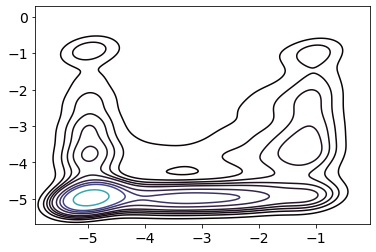

In [17]:
sns.kdeplot(np.clip(pred_k, -5, -1), valid_data[2], fill=False, cmap="mako")

In [18]:
# every single model I trained on in vivo data predicts the last kinetic rate to be -1
# so it must be some differences between in vitro vs in vivo
pred_k

array([-1.7747407 , -0.99999994, -0.99999994, ..., -5.0620675 ,
       -6.9999995 , -3.1433046 ], dtype=float32)

In [19]:
valid_data[2]

array([-1.03242438, -1.15347785, -0.93014961, ..., -5.        ,
       -5.        , -5.        ])

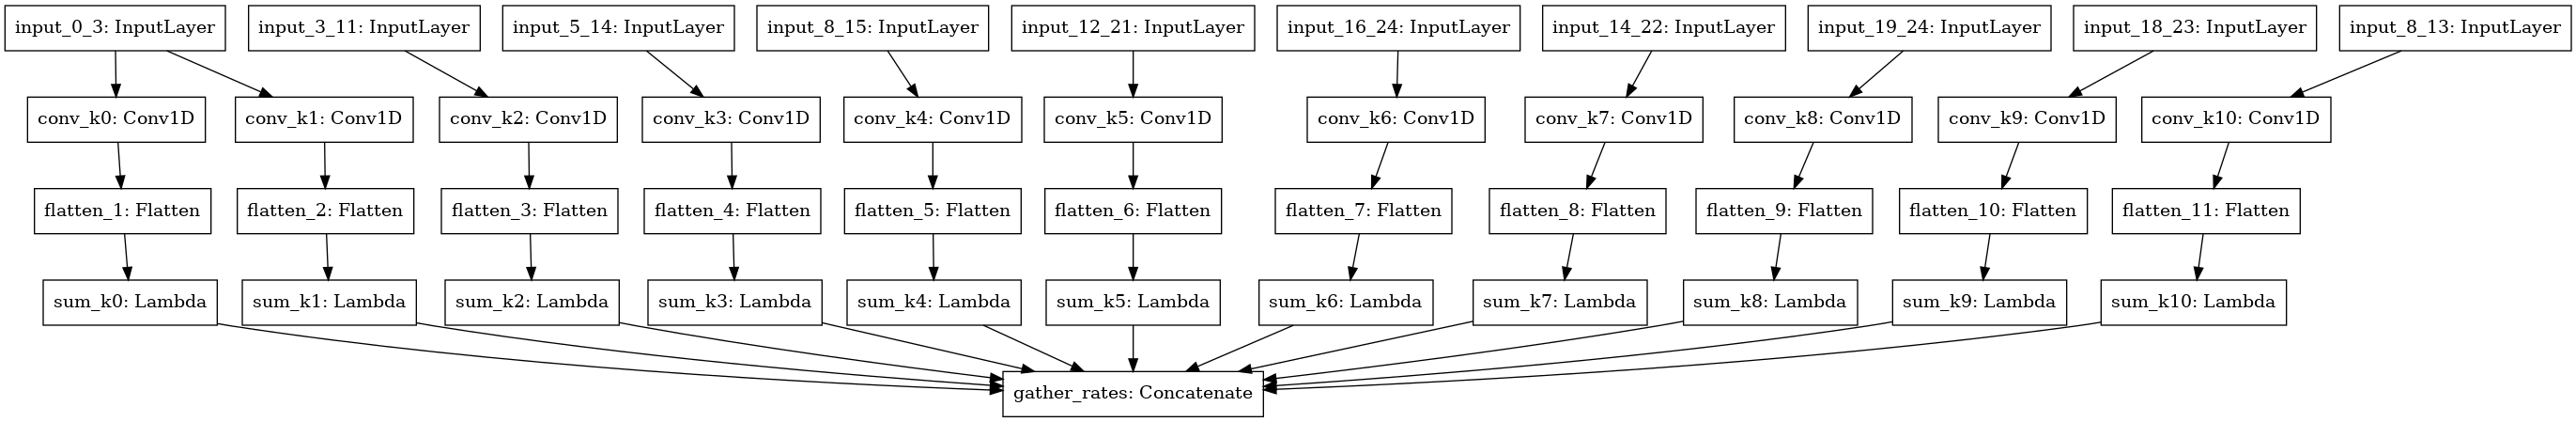

In [20]:
tf.keras.utils.plot_model(layer_dict[k_layer_name].kinn_header)

In [21]:
layer_dict["output_final"].get_weights()

[array([[1.8851742]], dtype=float32), array([4.229836], dtype=float32)]

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Oct 28 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

scipy     : 1.7.3
seaborn   : 0.11.1
pandas    : 1.0.3
tensorflow: 1.15.0
h5py      : 2.10.0
numpy     : 1.19.5
matplotlib: 3.4.3
src       : 0.0.3

Watermark: 2.3.1

